# Knowledge Tracing without Time Information

In [1]:
import itertools
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import os
import random

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

relu = nn.ReLU()

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
def set_seed(seed):
    random.seed(seed)  # Pythonのrandomモジュールのシードを固定
    np.random.seed(seed)  # NumPyのシードを固定
    torch.manual_seed(seed)  # PyTorchのCPUシードを固定
    torch.cuda.manual_seed(seed)  # PyTorchのGPUシードを固定
    torch.cuda.manual_seed_all(seed)  # マルチGPU環境でのシード固定
    torch.backends.cudnn.deterministic = True  # 再現性のためにCuDNNを固定
    torch.backends.cudnn.benchmark = False  # 再現性のためにCuDNNベンチマークをOFF

set_seed(0)

## データ生成法

In [4]:
# 今の状態から次ノードへの遷移確率を計算
# 3-PLモデルを参考
def transition_probabilities(A, X, guessing=0.6):
    """
    Aは要素の依存関係を表す行列、Xは状態ベクトル
    """
    n = len(X)
    probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 未習得の要素に関して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 未習得
            probabilities[i] = DINA(A[i, :], X)

    mask = (probabilities != 0)
    non_zero_values = probabilities[mask]

    # 非ゼロ要素にsoftmaxを適用
    normalized_non_zero = softmax(non_zero_values)
    # 結果を元のサイズのテンソルに戻す
    probabilities[mask] = (1-guessing) * normalized_non_zero
    mask2 = (X == 0)
    probabilities[mask2] += guessing / mask2.sum()
    return probabilities

def DINA(Ai, X):
    """共にベクトル
    """
    mask = (Ai != 0) # 0でない要素のみ
    dina = np.min(X[mask] * Ai[mask]) if np.any(mask) else 1 # 全て習得もしくは必要アトリビュートがない場合
    return dina

def DINO(Ai, X):
    """共にベクトル
    """
    dino = np.sum(X * Ai) # 要素を持つほど大きい
    return dino

def softmax(x):
    exp_x = np.exp(x - np.max(x)) # オーバーフロー対策
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [5]:
# 人工データ生成
def generate_data2(A, num_data_per_step, all_path=False):
    """num_data_per_step: 各ステップで生成するデータ数"""

    n = len(A) # 要素数
    initial_X = np.array([0] * n) # 初期状態

    dataset = []
    # 各ステップでデータを生成
    for i in range(1, n+1): # 習得数
        for j in range(num_data_per_step):  # 各層の学生数

            test_i = random.randint(i, n)

            X = initial_X.copy()  # 初期状態からスタート
            
            # i問正解させる
            for k in range(1, test_i+1):
                pre_X = X.copy()  # 遷移前の状態
                
                # 確率に基づいて遷移
                probabilities = transition_probabilities(A, X)
                next_correct_problem = np.random.choice(n, p=probabilities)
                X[next_correct_problem] = 1

                if k == i:
                    train_X = X.clip(min=0).copy()
                    
                # 全ての経路を使う場合
                if all_path:
                    # 差分を教師データとして使用
                    target_Y = X.clip(min=0)  # 新たな習得部分のみを1
                    dataset.append((pre_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
            
            if not all_path:
                # 最終的な状態を教師データとして使用
                test_X = X.clip(min=0).copy() - train_X
                dataset.append((initial_X.copy(), train_X, test_X))

    return dataset

# 人工データ生成
def generate_data_all(A, num_data_per_step, all_path=False):
    """num_data_per_step: 各ステップで生成するデータ数"""

    n = len(A) # 要素数
    initial_X = np.array([0] * n) # 初期状態
    
    dataset = []
    dataset_step = []   
    dataset_all = []
    # 各ステップでデータを生成
    for i in range(1, n+1): # 習得数
        for j in range(num_data_per_step):  # 各層の学生数

            test_i = random.randint(i, n)

            X = initial_X.copy()  # 初期状態からスタート
            initial_X_step = np.array([0] * n) # 2stepの初期状態
            
            # i問正解させる
            for k in range(1, test_i+1):
                pre_X = X.copy()  # 遷移前の状態
                
                # 確率に基づいて遷移
                probabilities = transition_probabilities(A, X)
                next_correct_problem = np.random.choice(n, p=probabilities)
                X[next_correct_problem] = 1

                if k == i:
                    train_X = X.clip(min=0).copy()


                if k <= i:
                    # 中間パスを記録
                    if k == i//2:
                        X_step = X.clip(min=0).copy() - initial_X_step
                        dataset_step.append((initial_X_step.copy(), X_step))
                        initial_X_step = X.clip(min=0).copy()

                    # 全ての道筋
                    all_X = X.clip(min=0).copy() - pre_X
                    dataset_all.append((pre_X.copy(), all_X))
            
            # 最終的な状態を教師データとして使用
            test_X = X.clip(min=0).copy() - train_X
            dataset.append((initial_X.copy(), train_X, test_X))

            X_step = train_X.copy() - initial_X_step
            dataset_step.append((initial_X_step.copy(), X_step))
            
    return dataset, dataset_step, dataset_all

## モデル構築

In [6]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [7]:
bcsoftmax1d = BCSoftmax1d.apply

# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, num_components):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_components, num_components)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

In [8]:
def train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, hyp, reg):
    model.train()
    data, targets = train_X.to(device), train_Y.to(device)
    optimizer.zero_grad()

    outputs = []
    relu = nn.ReLU()
    # データによってループ回数が異なる
    for i, target in enumerate(targets):
        # 初期budget
        c = torch.ones(num_components, dtype=torch.float32, device=device).to(device)
        c = c - data[i]
        state = data[i].to(device)

        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となってしまう
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)  # 状態から遷移確率を計算
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # 予算の更新

        outputs.append(state - data[i])  # 最終的な出力を保存
    
    outputs = torch.stack(outputs)

    # 正則化項
    loss_o = criterion(outputs, targets)
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
    return float(loss)


def val_loss(model, num_components, device, val_X, val_Y, criterion, hyp, reg):
    model.eval()
    data, targets = val_X.to(device), val_Y.to(device)
    relu = nn.ReLU()

    with torch.no_grad():
        val_outputs = []
        for i, target in enumerate(targets):
            c = torch.ones(num_components, dtype=torch.float32, device=device).to(device)
            c = c - data[i]
            state = data[i].to(device)
            for _ in range(int(sum(target))):
                # もしcの和が1なら、rが0となってしまう
                if c.sum() <= 1:
                    prob = c
                else:
                    prob = model(state, c)  # 状態から遷移確率を計算
                state = prob + state  # 状態の更新
                c = relu(c - prob)  # 予算の更新

            val_outputs.append(state - data[i])

        val_outputs = torch.stack(val_outputs)

        # 正則化項
        loss_o = criterion(val_outputs, targets)
        if reg == 'L1':
            loss = loss_o + hyp * l1(model)
        elif reg == 'L2':
            loss = loss_o + hyp * l2(model)
        else:
            loss = loss_o
    return float(loss)

def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

In [9]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 8:2に分割
def split_balanced_data(train_X, train_Y, ratio=0.8):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    train_X_data, train_Y_data, val_X_data, val_Y_data = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        train_X_data.extend([x for x, y in train_data])
        train_Y_data.extend([y for x, y in train_data])
        val_X_data.extend([x for x, y in val_data])
        val_Y_data.extend([y for x, y in val_data])

    return train_X_data, train_Y_data, val_X_data, val_Y_data

In [10]:
import argparse

parser = argparse.ArgumentParser()

# 要素（問題）数・依存行列の種類。実験回数
parser.add_argument('--component_size', type=int  , default=10    , help='number of components')
parser.add_argument('--num_paterns'   , type=int  , default=1    , help='number of patterns')
parser.add_argument('--trials'        , type=int  , default=1    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=1500 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.01 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.8  , help='split ratio of training and validation data')
parser.add_argument('--num_stepdata'  , type=int  , default=10   , help='number of data per step')
parser.add_argument('--all_path'      , type=bool , default=False, help='use all path or not')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')



_StoreAction(option_strings=['--hyperparameter'], dest='hyperparameter', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, help='hyperparameter for regularization', metavar=None)

In [11]:
# テスト用のダミー引数
args, unknown = parser.parse_known_args()
print('args:', args)

args: Namespace(component_size=10, num_paterns=1, trials=1, epochs=1500, lr=0.01, early_stopping=10, split_ratio=0.8, num_stepdata=10, all_path=False, Regularization='L1', hyperparameter=0.001)


## データ生成

In [12]:
"""やってること
・初期状態から遷移する数を1からn/2の範囲で指定
・各列に着目し、親ノードに繋がるように調整
・何かしらの子ノードを持つように調整
"""
def dependency_matrix(n): # n: 要素数

    # 下三角行列をランダム生成（対角成分は0にする）
    A = np.tril(np.random.randint(0, 2, (n, n)), k=-1).astype(float)

    # 初期状態からの遷移をいくつ作るか
    init = np.random.randint(1, int(n / 2)+1) # [1, n/2+1)
    print(init)
    for i in range(init):
        A[i] = 0
    
    # 要素j=0,...,n-2は、要素j+1,...,n-1に依存するように調整
    for j in range(n-1):
        if not A[:, j].any():  # 先に依存関係がない場合
            c = np.random.randint(j+1, n)  # ランダムに行を選択
            A[c, j] = 1
            
    # 各ノードが必ず1つの依存関係を持つように調整
    for k in range(init, n):  # 最後のノード以外をチェック
        if not A[k, :].any():  # 出次数が0のノードを確認
            # ランダムに依存関係を作る
            d = np.random.randint(0, k)  # 1からi-1までの数字から選択
            A[k, d] = 1

    num_components = len(A)  # 要素数
    return A, num_components

# # 依存関係行列
# A = np.array([
#     [0, 0, 0, 0, 0, 0],  # 0番目の要素は無視
#     [1, 0, 0, 0, 0, 0],  # 要素1は状態に依存しない
#     [1, 0, 0, 0, 0, 0],  # 要素2は状態に依存しない
#     [0, 1, 1, 0, 0, 0],  # 要素3は要素1と2に依存
#     [0, 0, 0, 1, 0, 0],  # 要素4は要素3に依存
#     [0, 0, 0, 0, 1, 0]   # 要素5は要素4に依存
# ], dtype = float)*3

# # 0でない要素の数で割る処理
# nonzero_counts = np.count_nonzero(A[1:], axis=1, keepdims=True)
# A[1:] = np.where(nonzero_counts != 0, A[1:] / nonzero_counts, 0)

# num_components = len(A)-1  # 要素数

## 評価指標

### KL Divergence

$$ D_{\text{KL}}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)} $$

---

### Hellinger距離

$$ H(p, q) = \frac{1}{\sqrt{2}} \left\| \sqrt{p} - \sqrt{q} \right\|_2 $$

$$ \left\| \sqrt{p} - \sqrt{q} \right\|_2 = \sqrt{\sum_{i} \left( \sqrt{p(i)} - \sqrt{q(i)} \right)^2} $$

---

### Jensen-Shannon Divergence

$$ D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}(p \| m) + \frac{1}{2} D_{\text{KL}}(q \| m) $$

$$ m = \frac{1}{2}(p + q) $$

In [13]:
def kl_divergence(p, q, epsilon=1e-10):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # pとqにスムージングを適用
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # KLダイバージェンスの計算
    return np.sum(p * np.log(p / q))

def hellinger_distance(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    # Hellinger距離の計算式: H(p, q) = (1/√2) * ||√p - √q||_2
    sqrt_p = np.sqrt(p)
    sqrt_q = np.sqrt(q)
    distance = np.sqrt(np.sum((sqrt_p - sqrt_q) ** 2)) / np.sqrt(2)
    return np.mean(distance)

def js_divergence(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    m = 0.5 * (p + q)
    jsd = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    
    # 各サンプルの平均を返す
    return np.mean(jsd)

def weight_difficulty(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)

    

In [14]:
def evaluate(model, upper_model, step_model, all_model, num_components, states, state_counts, A, data, comparison = True):
    model.eval()
    upper_model.eval()
    step_model.eval()
    all_model.eval()

    node_probabilities = defaultdict(float)
    start = tuple(0 for _ in range(num_components))
    node_probabilities[start] = 1

    KL, HD, JSD = 0, 0, 0
    upper_KL, upper_HD, upper_JSD = 0, 0, 0
    step_KL, step_HD, step_JSD = 0, 0, 0
    all_KL, all_HD, all_JSD = 0, 0, 0
    d_KL, d_HD, d_JSD = 0, 0, 0
    c_KL, c_HD, c_JSD = 0, 0, 0

    for state in states:
        if state == (1,) * (num_components):  # 最後のノードでは遷移がないのでスキップ
            continue

        probabilities = transition_probabilities(A, np.array(state))

        # 比較手法
        c_pred = []
        total = 0

        # 最下層から頂点までのノードの分布を順に計算
        for i in range(num_components):
            if state[i] == 0:  # 未習得
                # 遷移後の状態
                next_state = list(state)
                next_state[i] = 1
                next_state = tuple(next_state)
                node_probabilities[next_state] += probabilities[i] * node_probabilities[state]

                c_pred.append(state_counts[next_state])
                total += state_counts[next_state]
            else:
                c_pred.append(0)
        
        # budget
        c_g = torch.ones(num_components, dtype=torch.float32)
        c_g = relu(c_g - torch.tensor(state, dtype=torch.float32))

        # 状態とその予測分布
        state_tensor = torch.tensor(state, dtype=torch.float32)
        predicted_values = model(state_tensor, c_g) # 予測値を計算
        upper_predicted_values = upper_model(state_tensor, c_g) # 予測値を計算
        step_predicted_values = step_model(state_tensor, c_g) # 予測値を計算
        all_predicted_values = all_model(state_tensor, c_g) # 予測値を計算

        # 評価指標の計算
        KL += node_probabilities[state] * kl_divergence(probabilities, predicted_values.detach())
        HD += node_probabilities[state] * hellinger_distance(probabilities, predicted_values.detach())
        JSD += node_probabilities[state] * js_divergence(probabilities, predicted_values.detach())

        upper_KL += node_probabilities[state] * kl_divergence(probabilities, upper_predicted_values.detach())
        upper_HD += node_probabilities[state] * hellinger_distance(probabilities, upper_predicted_values.detach())
        upper_JSD += node_probabilities[state] * js_divergence(probabilities, upper_predicted_values.detach())

        step_KL += node_probabilities[state] * kl_divergence(probabilities, step_predicted_values.detach())
        step_HD += node_probabilities[state] * hellinger_distance(probabilities, step_predicted_values.detach())
        step_JSD += node_probabilities[state] * js_divergence(probabilities, step_predicted_values.detach())

        all_KL += node_probabilities[state] * kl_divergence(probabilities, all_predicted_values.detach())
        all_HD += node_probabilities[state] * hellinger_distance(probabilities, all_predicted_values.detach())
        all_JSD += node_probabilities[state] * js_divergence(probabilities, all_predicted_values.detach())

        # 難易度ベース
        difficulties = np.sum(np.array(data), axis=0)
        candidate_indices = np.where(np.array(state) == 0)[0]
        difficulties_pred = np.zeros_like(difficulties)
        difficulties_pred[candidate_indices] = difficulties[candidate_indices]
        difficulties_pred = difficulties_pred / np.sum(difficulties_pred)
        
        d_KL += node_probabilities[state] * kl_divergence(probabilities, difficulties_pred)
        d_HD += node_probabilities[state] * hellinger_distance(probabilities, difficulties_pred)
        d_JSD += node_probabilities[state] * js_divergence(probabilities, difficulties_pred)
        
        # 比較手法
        if total > 0:
            c_pred = np.array(c_pred) / total
        
        c_KL += node_probabilities[state] * kl_divergence(probabilities, c_pred)
        c_HD += node_probabilities[state] * hellinger_distance(probabilities, c_pred)
        c_JSD += node_probabilities[state] * js_divergence(probabilities, c_pred)
    
    if comparison:
        # 最終的な値をPythonのfloatにキャストする
        return float(KL), float(upper_KL), float(step_KL), float(all_KL), float(d_KL), float(c_KL), float(HD), float(upper_HD), float(step_HD), float(all_HD), float(d_HD), float(c_HD), float(JSD), float(upper_JSD), float(step_JSD), float(all_JSD), float(d_JSD), float(c_JSD)
    else:
        return float(KL), float(HD), float(JSD)



In [15]:
import csv
from datetime import datetime

# 保存フォルダーの作成
save_folder = "./evaluation_results"
os.makedirs(save_folder, exist_ok=True)

# 日付の取得
today = datetime.now().strftime("%Y-%m-%d")

# ファイル名設定
results_csv = os.path.join(save_folder, f"{today}_{args}.csv")

comparison = True

# 初回にヘッダーを追加する
if comparison:
    header = [
    "Iteration", 
    "KL_提案手法",
    "KL_上限手法",
    "KL_step手法",
    "KL_all手法",
    "KL_難易度ベース",
    "KL_比較手法",
    "HD_提案手法",
    "HD_上限手法",
    "HD_step手法",
    "HD_all手法",
    "HD_難易度ベース",
    "HD_比較手法",
    "JSD_提案手法",
    "JSD_上限手法",
    "JSD_step手法",
    "JSD_all手法",
    "JSD_難易度ベース",
    "JSD_比較手法",
    "topk_提案手法",
    "topk_上限手法",
    "topk_step手法",
    "topk_all手法",
    "topk_難易度ベース",
    "topk_比較手法",
    "topk_ランダム"
]
else:
    header = [
    "Iteration", 
    "KL",
    "HD",
    "JSD"
]

try:
    with open(results_csv, "x", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
except FileExistsError:
    pass  # ファイルが既に存在する場合は何もしない

In [16]:
A, num_components = dependency_matrix(args.component_size)

# データ生成
X_init = np.array([0] * num_components)
s_data, step_data, all_data = generate_data_all(A, args.num_stepdata, args.all_path)


2


In [17]:
print(A)
print(step_data[-5:])
print(all_data[-5:])
print("step_data:", len(step_data))
print("all_data:", len(all_data))
print("s_data:", len(s_data))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 0.]]
[(array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0]), array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0])), (array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0]), array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0])), (array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0]), array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]))]
[(array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])), (array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])), (array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1]), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])), (array([1, 1, 0, 1, 1, 1, 1

## 学習

In [18]:
seed = 0
set_seed(seed)
for patern in range(args.num_paterns):
    print(f"Patern: {patern+1}")
    #　依存関係行列の生成
    A, num_components = dependency_matrix(args.component_size)
    print(A)

    for trial in range(args.trials):
        print(f"Trial: {trial+1}")
        set_seed(seed)
        seed += 1
        
        # データ生成
        X_init = np.array([0] * num_components)
        s_data, step_data, all_data = generate_data_all(A, args.num_stepdata, args.all_path)
        data_X = [input_data for input_data, _, _ in s_data]
        data_Y = [target_data for _, target_data, _ in s_data]
        data_Y2 = [test_data for _, _, test_data in s_data]
        
        data_X = np.array(data_X)
        data_Y = np.array(data_Y)
        shuffle_data = np.random.permutation(data_X.shape[0])
        upper_data_X = data_X[shuffle_data]
        upper_data_Y = data_Y[shuffle_data]
        train_X_data, train_Y_data, val_X_data, val_Y_data = split_balanced_data(data_X, data_Y, args.split_ratio)

        "上限モデル定義"
        upper_data_X = np.concatenate([data_X, data_Y], axis=0)
        upper_data_Y = np.concatenate([data_Y, data_Y2], axis=0)
        shuffle_data = np.random.permutation(upper_data_X.shape[0])
        upper_data_X = upper_data_X[shuffle_data]
        upper_data_Y = upper_data_Y[shuffle_data]
        upper_train_X, upper_train_Y, upper_val_X, upper_val_Y = split_balanced_data(upper_data_X, upper_data_Y, args.split_ratio)

        upper_train_X = torch.tensor(upper_train_X, dtype=torch.float32)
        upper_train_Y = torch.tensor(upper_train_Y, dtype=torch.float32)
        upper_val_X = torch.tensor(upper_val_X, dtype=torch.float32)
        upper_val_Y = torch.tensor(upper_val_Y, dtype=torch.float32)
        
        print(f"Train data: {len(upper_train_X)}, Validation data: {len(upper_val_X)}")

        # モデル、損失関数、最適化関数の設定
        upper_model = Model(num_components)  # 要素数+初期状態
        upper_criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
        upper_optimizer = optim.Adam(upper_model.parameters(), lr=args.lr)

        upper_model = upper_model.to(device)

        # ロスの初期化
        upper_best_val_loss = float('inf')
        upper_valid_loss_min = float('inf')
        upper_early_stopping_count = 0

        # 試行ごとのロス値を記録するリスト
        upper_training_losses = []
        upper_validation_losses = []
        
        for upper_epoch in range(args.epochs):
            upper_train_loss = train(upper_model, num_components, device, upper_train_X, upper_train_Y, upper_criterion, upper_optimizer, upper_epoch, args.hyperparameter, args.Regularization)
            upper_valid_loss = val_loss(upper_model, num_components, device, upper_val_X, upper_val_Y, upper_criterion, args.hyperparameter, args.Regularization)
            upper_valid_loss_min = min(upper_valid_loss_min, upper_valid_loss)
            
            upper_training_losses.append(upper_train_loss)
            upper_validation_losses.append(upper_valid_loss)

            if upper_valid_loss_min < upper_valid_loss:
                upper_early_stopping_count += 1
            else:
                upper_early_stopping_count = 0
                # torch.save(model.state_dict(), f"upper_{args}_{lr}_{traial}.pth")
                
            if upper_early_stopping_count >= args.early_stopping:
                print(f"Early stopping at epoch {upper_epoch}")
                break

        print(f"Best validation loss: {upper_valid_loss_min}")



        "stepモデル定義"
        step_data_X = [input_data for input_data, _ in step_data]
        step_data_Y = [target_data for _, target_data in step_data]
        step_data_X = np.array(step_data_X)
        step_data_Y = np.array(step_data_Y)
        shuffle_data = np.random.permutation(step_data_X.shape[0])
        step_data_X = step_data_X[shuffle_data]
        step_data_Y = step_data_Y[shuffle_data]
        step_train_X, step_train_Y, step_val_X, step_val_Y = split_balanced_data(step_data_X, step_data_Y, args.split_ratio)

        step_train_X = torch.tensor(step_train_X, dtype=torch.float32)
        step_train_Y = torch.tensor(step_train_Y, dtype=torch.float32)
        step_val_X = torch.tensor(step_val_X, dtype=torch.float32)
        step_val_Y = torch.tensor(step_val_Y, dtype=torch.float32)
        
        print(f"Train data: {len(step_train_X)}, Validation data: {len(step_val_X)}")

        # モデル、損失関数、最適化関数の設定
        step_model = Model(num_components)  # 要素数+初期状態
        step_criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
        step_optimizer = optim.Adam(step_model.parameters(), lr=args.lr)

        step_model = step_model.to(device)

        # ロスの初期化
        step_best_val_loss = float('inf')
        step_valid_loss_min = float('inf')
        step_early_stopping_count = 0

        # 試行ごとのロス値を記録するリスト
        step_training_losses = []
        step_validation_losses = []
        
        for step_epoch in range(args.epochs):
            step_train_loss = train(step_model, num_components, device, step_train_X, step_train_Y, step_criterion, step_optimizer, step_epoch, args.hyperparameter, args.Regularization)
            step_valid_loss = val_loss(step_model, num_components, device, step_val_X, step_val_Y, step_criterion, args.hyperparameter, args.Regularization)
            step_valid_loss_min = min(step_valid_loss_min, step_valid_loss)
            
            step_training_losses.append(step_train_loss)
            step_validation_losses.append(step_valid_loss)

            if step_valid_loss_min < step_valid_loss:
                step_early_stopping_count += 1
            else:
                step_early_stopping_count = 0
                # torch.save(model.state_dict(), f"step_{args}_{lr}_{traial}.pth")
                
            if step_early_stopping_count >= args.early_stopping:
                print(f"Early stopping at epoch {step_epoch}")
                break

        print(f"Best validation loss: {step_valid_loss_min}")


        "allモデル定義"
        all_data_X = [input_data for input_data, _ in all_data]
        all_data_Y = [target_data for _, target_data in all_data]
        all_data_X = np.array(all_data_X)
        all_data_Y = np.array(all_data_Y)
        shuffle_data = np.random.permutation(all_data_X.shape[0])
        all_data_X = all_data_X[shuffle_data]
        all_data_Y = all_data_Y[shuffle_data]
        all_train_X, all_train_Y, all_val_X, all_val_Y = split_balanced_data(all_data_X, all_data_Y, args.split_ratio)

        all_train_X = torch.tensor(all_train_X, dtype=torch.float32)
        all_train_Y = torch.tensor(all_train_Y, dtype=torch.float32)
        all_val_X = torch.tensor(all_val_X, dtype=torch.float32)
        all_val_Y = torch.tensor(all_val_Y, dtype=torch.float32)
        
        print(f"Train data: {len(all_train_X)}, Validation data: {len(all_val_X)}")

        # モデル、損失関数、最適化関数の設定
        all_model = Model(num_components)  # 要素数+初期状態
        all_criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
        all_optimizer = optim.Adam(all_model.parameters(), lr=args.lr)

        all_model = all_model.to(device)

        # ロスの初期化
        all_best_val_loss = float('inf')
        all_valid_loss_min = float('inf')
        all_early_stopping_count = 0

        # 試行ごとのロス値を記録するリスト
        all_training_losses = []
        all_validation_losses = []
        
        for all_epoch in range(args.epochs):
            all_train_loss = train(all_model, num_components, device, all_train_X, all_train_Y, all_criterion, all_optimizer, all_epoch, args.hyperparameter, args.Regularization)
            all_valid_loss = val_loss(all_model, num_components, device, all_val_X, all_val_Y, all_criterion, args.hyperparameter, args.Regularization)
            all_valid_loss_min = min(all_valid_loss_min, all_valid_loss)
            
            all_training_losses.append(all_train_loss)
            all_validation_losses.append(all_valid_loss)

            if all_valid_loss_min < all_valid_loss:
                all_early_stopping_count += 1
            else:
                all_early_stopping_count = 0
                # torch.save(model.state_dict(), f"all_{args}_{lr}_{traial}.pth")
                
            if all_early_stopping_count >= args.early_stopping:
                print(f"Early stopping at epoch {all_epoch}")
                break

        print(f"Best validation loss: {all_valid_loss_min}")




        # PyTorch テンソルに変換
        train_X = torch.tensor(train_X_data, dtype=torch.float32)
        train_Y = torch.tensor(train_Y_data, dtype=torch.float32)
        val_X = torch.tensor(val_X_data, dtype=torch.float32)
        val_Y = torch.tensor(val_Y_data, dtype=torch.float32)

        print(f"Train data: {len(train_X)}, Validation data: {len(val_X)}")
        
        "状態定義"
        states = [state for state in itertools.product([0, 1], repeat=num_components)]
        states = sorted(states, key=lambda state: sum(state))

        # 状態ごとの学生数をカウント
        state_counts = defaultdict(int)
        for i in range(len(train_X)):
            state_tuple = tuple(map(int, train_X[i] + train_Y[i]))
            state_counts[state_tuple] += 1

        "モデル定義"
        # モデル、損失関数、最適化関数の設定
        model = Model(num_components)  # 要素数+初期状態
        criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

        model = model.to(device)

        # ロスの初期化
        best_val_loss = float('inf')
        valid_loss_min = float('inf')
        early_stopping_count = 0

        # 試行ごとのロス値を記録するリスト
        training_losses = []
        validation_losses = []
        
        for epoch in range(args.epochs):
            train_loss = train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, args.hyperparameter, args.Regularization)
            valid_loss = val_loss(model, num_components, device, val_X, val_Y, criterion, args.hyperparameter, args.Regularization)
            valid_loss_min = min(valid_loss_min, valid_loss)
            
            training_losses.append(train_loss)
            validation_losses.append(valid_loss)

            if valid_loss_min < valid_loss:
                early_stopping_count += 1
            else:
                early_stopping_count = 0
                # torch.save(model.state_dict(), f"{args}_{lr}_{traial}.pth")
                
            if early_stopping_count >= args.early_stopping:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Best validation loss: {valid_loss_min}")



        eval_results = evaluate(model, upper_model, step_model, all_model, num_components, states, state_counts, A, data_Y, comparison)
        # 試行ごとの指標をCSVに追記
        with open(results_csv, "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                trial + 1,
                *eval_results
            ])

Patern: 1
2
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 0.]]
Trial: 1
Train data: 156, Validation data: 44


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_13384/2946551475.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  upper_train_X = torch.tensor(upper_train_X, dtype=torch.float32)


Early stopping at epoch 49
Best validation loss: 8.624956130981445
Train data: 152, Validation data: 38
Epoch 100, Loss: 6.1343
Early stopping at epoch 161
Best validation loss: 6.225030422210693
Train data: 440, Validation data: 110
Epoch 100, Loss: 2.1042
Epoch 200, Loss: 2.0802
Epoch 300, Loss: 2.0710
Early stopping at epoch 336
Best validation loss: 2.1423258781433105
Train data: 80, Validation data: 20
Early stopping at epoch 31
Best validation loss: 12.509257316589355


In [19]:
print(s_data[:5])
print(step_data[:5])
print(all_data[:5])
print(len(s_data))
print(len(step_data))
print(len(all_data))

[(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]), array([0, 1, 1, 1, 0, 1, 0, 1, 0, 1])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))]
[(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))]
[(a

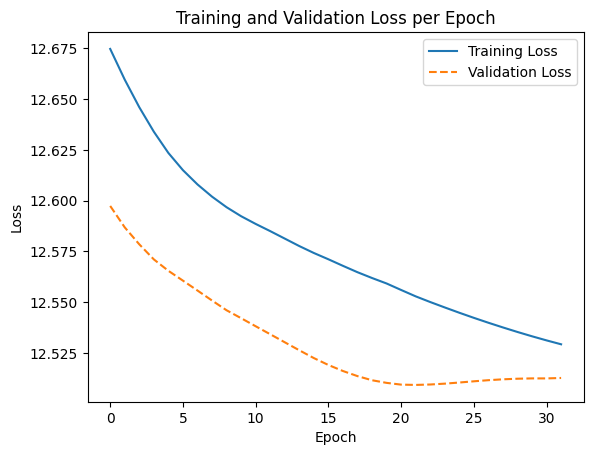

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [21]:
test_data = generate_data2(A, int(args.num_stepdata * 0.5), args.all_path)
test_X = [input_data for input_data, _, _ in test_data]
test_input = [target_data for _, target_data, _ in test_data]
test_target = [test_data for _, _, test_data in test_data]

predicted_attributes = []
upper_predicted_attributes = []
step_predicted_attributes = []
all_predicted_attributes = []
com_proposed_input = []
num_components = len(test_input[0])
for i in range(len(test_input)):
    # 提案モデル
    attribute = torch.tensor(test_input[i], dtype=torch.float32)
    c = torch.ones(num_components, dtype=torch.float32)
    c = c - attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if c.sum() <= 1:
            prob = c
        else:
            prob = model(attribute , c)  # 状態から遷移確率を計算
        attribute = prob + attribute  # 状態の更新
        c = relu(c - prob)  # 予算の更新

    # 上限モデル
    upper_attribute = torch.tensor(test_input[i], dtype=torch.float32)
    upper_c = torch.ones(num_components, dtype=torch.float32)
    upper_c = upper_c - upper_attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if upper_c.sum() <= 1:
            upper_prob = upper_c
        else:
            upper_prob = upper_model(upper_attribute , upper_c)  # 状態から遷移確率を計算
        upper_attribute = upper_prob + upper_attribute  # 状態の更新
        upper_c = relu(upper_c - upper_prob)  # 予算の更新

    # stepモデル
    step_attribute = torch.tensor(test_input[i], dtype=torch.float32)
    step_c = torch.ones(num_components, dtype=torch.float32)
    step_c = step_c - step_attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if step_c.sum() <= 1:
            step_prob = step_c
        else:
            step_prob = step_model(step_attribute , step_c)  # 状態から遷移確率を計算
        step_attribute = step_prob + step_attribute  # 状態の更新
        step_c = relu(step_c - step_prob)  # 予算の更新
    
    # allモデル
    all_attribute = torch.tensor(test_input[i], dtype=torch.float32)
    all_c = torch.ones(num_components, dtype=torch.float32)
    all_c = all_c - all_attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if all_c.sum() <= 1:
            all_prob = all_c
        else:
            all_prob = all_model(all_attribute , all_c)  # 状態から遷移確率を計算
        all_attribute = all_prob + all_attribute  # 状態の更新
        all_c = relu(all_c - all_prob)  # 予算の更新

    # 比較
    com_prob = []
    total = 0
    for j in range(num_components):
        if attribute[j] == 0 and sum(get_attribute) != 0:
            next_attribute = list(attribute.tolist())
            next_attribute[j] = 1
            next_attribute = tuple(next_attribute)
            # print(state_counts[next_attribute])
            com_prob.append(state_counts[next_attribute])
            total += state_counts[next_attribute]
        else:
            com_prob.append(0)
    if total != 0 and sum(get_attribute) != 0:
        # print(np.array(com_prob)/total)
        com_proposed_input.append(np.array(com_prob)/total)
    else:
        com_proposed_input.append(com_prob)

    predicted_attributes.append(attribute.detach().numpy()-test_input[i])
    upper_predicted_attributes.append(upper_attribute.detach().numpy()-test_input[i])
    step_predicted_attributes.append(step_attribute.detach().numpy()-test_input[i])
    all_predicted_attributes.append(all_attribute.detach().numpy()-test_input[i])

In [22]:
difficulties = np.sum(test_input, axis=0) 
print(len(test_input))
print(difficulties)
difficulties = difficulties / difficulties.sum()  # 正規化
print("難易度ベース", difficulties)
for i in range(5):
    print("入力", test_input[i])
    print("提案モデル:", predicted_attributes[i])
    print("上限モデル:", upper_predicted_attributes[i])
    print("stepモデル:", step_predicted_attributes[i])
    print("allモデル:", all_predicted_attributes[i])
    print("比較手法:", com_proposed_input[i])
    print("正解:", test_target[i])
    print()

50
[38 45 31 30 24 22 25 20 18 22]
難易度ベース [0.13818182 0.16363636 0.11272727 0.10909091 0.08727273 0.08
 0.09090909 0.07272727 0.06545455 0.08      ]
入力 [0 1 0 0 0 0 0 0 0 0]
提案モデル: [1.         0.         1.         0.98812449 0.3715716  0.33442059
 0.34730226 0.28728423 0.36548498 0.30581188]
上限モデル: [1.         0.         1.         1.         0.35416764 0.41495132
 0.36606133 0.19812314 0.34751379 0.31918269]
stepモデル: [1.         0.         1.         1.         0.47304702 0.16272137
 0.31067663 0.12201944 0.59460443 0.33693123]
allモデル: [1.         0.         1.         1.         1.         0.30716807
 0.55740523 0.05656353 0.0661188  0.01274419]
比較手法: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
正解: [1 0 1 0 0 1 1 1 0 0]

入力 [0 1 0 0 0 0 0 0 0 0]
提案モデル: [1.         0.         1.         1.         1.         1.
 1.00000012 1.00000012 1.         1.        ]
上限モデル: [1.         0.         1.         1.         1.         1.
 1.         1.         1.         0.99999994]
stepモデル: [1.         0.       

In [37]:
data_Y = np.array(data_Y)
difficulties = np.sum(data_Y, axis=0) 
difficulties = difficulties / difficulties.sum()  # 正規化
print(difficulties)
# difficulties2 = np.sum(train_data1+train_data2, axis=0)
# difficulties = difficulties2 + difficulties
# print(difficulties)

top_k_accuracies = []
upper_topk_accuracies = []
step_topk_accuracies = []
all_topk_accuracies = []
top_k_random_accuracies = []
top_k_difficulties_accuracies = []

match_rate = []
upper_match_rate = []
step_match_rate = []
all_match_rate = []

proposed_scores = []
upper_proposed_scores = []
step_scores = []
all_scores = []
random_scores = []
difficulties_scores = []

ce = []
upper_ce = []
step_ce = []
all_ce = []
d_ce = []

for i in range(len(test_target)):
    get_attribute = test_target[i]
    k = int(sum(get_attribute))  # 1の個数を取得（明示的に int に変換）

    if k == 0:
        continue  # 1がない場合はスキップ
    
    # get_attribute の 1 の部分のインデックスを取得
    true_top_k = set(np.where(get_attribute == 1)[0])

    # predicted_attributes[i] の上位 k 個のインデックスを取得
    pred_top_k = set(np.argsort(predicted_attributes[i])[-k:])  # k を int に変換したのでOK
    upper_pred_top_k = set(np.argsort(upper_predicted_attributes[i])[-k:])
    # 一致するインデックスの数を計算
    accuracy = len(pred_top_k & true_top_k) / k  # 一致数 / k で正解率を計算
    upper_accuracy = len(upper_pred_top_k & true_top_k) / k

    # stepモデル
    step_pred_top_k = set(np.argsort(step_predicted_attributes[i])[-k:])
    step_accuracy = len(step_pred_top_k & true_top_k) / k
    # allモデル
    all_pred_top_k = set(np.argsort(all_predicted_attributes[i])[-k:])
    all_accuracy = len(all_pred_top_k & true_top_k) / k
    
    # ランダム
    random_top_k = set(np.where(test_input[i] == 0)[0])
    random_top_k = set(np.random.choice(list(random_top_k), k, replace=False))
    # 一致率を計算
    random_accuracy = len(random_top_k & true_top_k) / k

    # 難易度ベース
    candidate_indices = np.where(test_input[i] == 0)[0]  # [1, 3, 4]
    candidate_difficulties = difficulties[candidate_indices]
    sorted_indices = candidate_indices[np.argsort(candidate_difficulties)[::-1]]
    top_k_indices = sorted_indices[:k]
    difficulties_accuracy = len(set(top_k_indices) & true_top_k) / k

    top_k_accuracies.append(accuracy)
    upper_topk_accuracies.append(upper_accuracy)
    step_topk_accuracies.append(step_accuracy)
    all_topk_accuracies.append(all_accuracy)
    top_k_random_accuracies.append(random_accuracy)
    top_k_difficulties_accuracies.append(difficulties_accuracy)

    # 補正スコア
    difficulty_sum = sum(difficulties[j] for j in random_top_k)
    # print(len(true_top_k))
    # print(len(pred_top_k & true_top_k))
    # print("accuracy", accuracy)
    # for j in pred_top_k & true_top_k:
    #     value = predicted_attributes[i][j]
    #     difficulty = (difficulties[j] / difficulty_sum)
    #     print(f"predicted_attributes[{i}][{j}] = {value}, difficulties[{j}] = {difficulty}")
    #     # 必要に応じて計算結果も出力
    #     print(f" → {value} / {difficulty} = {value / difficulty}")
    proposed_score = sum(predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in pred_top_k & true_top_k)/k
    # print(proposed_score)
    proposed_scores.append(proposed_score)
    upper_proposed_score = sum(upper_predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in upper_pred_top_k & true_top_k)/k
    upper_proposed_scores.append(upper_proposed_score)
    step_score = sum(step_predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in step_pred_top_k & true_top_k)/k
    step_scores.append(step_score)
    all_score = sum(all_predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in all_pred_top_k & true_top_k)/k
    all_scores.append(all_score)
    random_score = sum((1/len(random_top_k & true_top_k))/(difficulties[j] / difficulty_sum) for j in random_top_k & true_top_k)/k
    random_scores.append(random_score)
    difficulties_score = sum(1 for j in set(top_k_indices) & true_top_k)/k
    difficulties_scores.append(difficulties_score)

    # print("diff", len(pred_top_k&set(top_k_indices)), len(upper_pred_top_k&set(top_k_indices))/k, upper_proposed_score)
    match_rate.append(len(pred_top_k&set(top_k_indices))/k)
    upper_match_rate.append(len(upper_pred_top_k&set(top_k_indices))/k)
    step_match_rate.append(len(step_pred_top_k&set(top_k_indices))/k)
    all_match_rate.append(len(all_pred_top_k&set(top_k_indices))/k)

    ce.append(-np.mean(np.log(predicted_attributes[i][list(true_top_k)])))
    upper_ce.append(-np.mean(np.log(upper_predicted_attributes[i][list(true_top_k)])))
    step_ce.append(-np.mean(np.log(step_predicted_attributes[i][list(true_top_k)])))
    all_ce.append(-np.mean(np.log(all_predicted_attributes[i][list(true_top_k)])))
    d_ce.append(-np.mean(np.log(difficulties[list(true_top_k)]/difficulty_sum)))



print("aaa")
print(np.array(predicted_attributes).shape)
print(difficulties.shape)
# 平均を計算（リストが空でない場合のみ）
average_accuracy = np.mean(top_k_accuracies) if top_k_accuracies else 0.0
average_upper_accuracy = np.mean(upper_topk_accuracies) if upper_topk_accuracies else 0.0
average_step_accuracy = np.mean(step_topk_accuracies) if step_topk_accuracies else 0.0
average_all_accuracy = np.mean(all_topk_accuracies) if all_topk_accuracies else 0.0
average_random_accuracy = np.mean(top_k_random_accuracies) if top_k_random_accuracies else 0.0
average_difficulties_accuracy = np.mean(top_k_difficulties_accuracies) if top_k_difficulties_accuracies else 0.0

average_match_rate = np.mean(match_rate) if match_rate else 0.0
average_upper_match_rate = np.mean(upper_match_rate) if upper_match_rate else 0.0
average_step_match_rate = np.mean(step_match_rate) if step_match_rate else 0.0
average_all_match_rate = np.mean(all_match_rate) if all_match_rate else 0.0

ce = np.mean(ce) if ce else 0.0
upper_ce = np.mean(upper_ce) if upper_ce else 0.0
step_ce = np.mean(step_ce) if step_ce else 0.0
all_ce = np.mean(all_ce) if all_ce else 0.0
d_ce = np.mean(d_ce) if d_ce else 0.0

average_proposed_score = np.mean(proposed_scores) if proposed_scores else 0.0
average_upper_proposed_score = np.mean(upper_proposed_scores) if upper_proposed_scores else 0.0
average_step_score = np.mean(step_scores) if step_scores else 0.0
average_all_score = np.mean(all_scores) if all_scores else 0.0
average_random_score = np.mean(random_scores) if random_scores else 0.0
average_difficulties_score = np.mean(difficulties_scores) if difficulties_scores else 0.0

# 結果の表示
# print(f"Top-k accuracies: {top_k_accuracies}")
# print(f"Top-k random accuracies: {top_k_random_accuracies}") # ランダムの場合
# print(f"Upper Top-k accuracies: {upper_topk_accuracies}")
# print(f"Top-k difficulties accuracies: {top_k_difficulties_accuracies}")

print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average upper accuracy: {average_upper_accuracy:.4f}")
print(f"Average step accuracy: {average_step_accuracy:.4f}")
print(f"Average all accuracy: {average_all_accuracy:.4f}")
print(f"Average random accuracy: {average_random_accuracy:.4f}")
print(f"Average difficulties accuracy: {average_difficulties_accuracy:.4f}")
print(average_accuracy, average_upper_accuracy, average_difficulties_accuracy, average_random_accuracy)

print(f"難易度ベースとの出力一致率: {average_match_rate:.4f}")
print(f"難易度ベースとの出力一致率（上限モデル）: {average_upper_match_rate:.4f}")
print(f"難易度ベースとの出力一致率（stepモデル）: {average_step_match_rate:.4f}")
print(f"難易度ベースとの出力一致率（allモデル）: {average_all_match_rate:.4f}")

# 値が小さい方が良い
print(f"Cross Entropy: {ce:.4f}")
print(f"Upper Cross Entropy: {upper_ce:.4f}")
print(f"Step Cross Entropy: {step_ce:.4f}")
print(f"All Cross Entropy: {all_ce:.4f}")
print(f"Difficulty Cross Entropy: {d_ce:.4f}")

# あんま変わらん？
# 補正スコア
print(f"Average proposed score: {average_proposed_score:.4f}")
print(f"Average upper proposed score: {average_upper_proposed_score:.4f}")
print(f"Average step score: {average_step_score:.4f}")
print(f"Average all score: {average_all_score:.4f}")
print(f"Average random score: {average_random_score:.4f}")
print(f"Average difficulties score: {average_difficulties_score:.4f}")

[0.14181818 0.13454545 0.12       0.10545455 0.09272727 0.08727273
 0.08       0.06909091 0.08909091 0.08      ]
aaa
(50, 10)
(10,)
Average accuracy: 0.6880
Average upper accuracy: 0.7505
Average step accuracy: 0.7395
Average all accuracy: 0.7678
Average random accuracy: 0.6705
Average difficulties accuracy: 0.7624
0.6880102040816326 0.7505102040816326 0.7624149659863946 0.6704931972789115
難易度ベースとの出力一致率: 0.8649
難易度ベースとの出力一致率（上限モデル）: 0.9175
難易度ベースとの出力一致率（stepモデル）: 0.9669
難易度ベースとの出力一致率（allモデル）: 0.9556
Cross Entropy: 0.5595
Upper Cross Entropy: 0.5706
Step Cross Entropy: 0.7427
All Cross Entropy: 0.7454
Difficulty Cross Entropy: 1.0490
Average proposed score: 2.6974
Average upper proposed score: 2.7480
Average step score: 2.7965
Average all score: 2.9879
Average random score: 0.8093
Average difficulties score: 0.7624


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Probabilities: [0.26 0.26 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06], Predicted Values: tensor([0.1144, 0.1582, 0.1327, 0.1255, 0.0758, 0.0743, 0.0862, 0.0655, 0.0993,
        0.0680], grad_fn=<BCSoftmax1dBackward>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1), Probabilities: [0.26666667 0.26666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.        ], Predicted Values: tensor([0.1771, 0.1998, 0.1218, 0.1277, 0.0692, 0.0646, 0.0830, 0.0583, 0.0986,
        0.0000], grad_fn=<BCSoftmax1dBackward>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 0, 0, 1, 0), Probabilities: [0.26666667 0.26666667 0.06666667 0.06666667 0

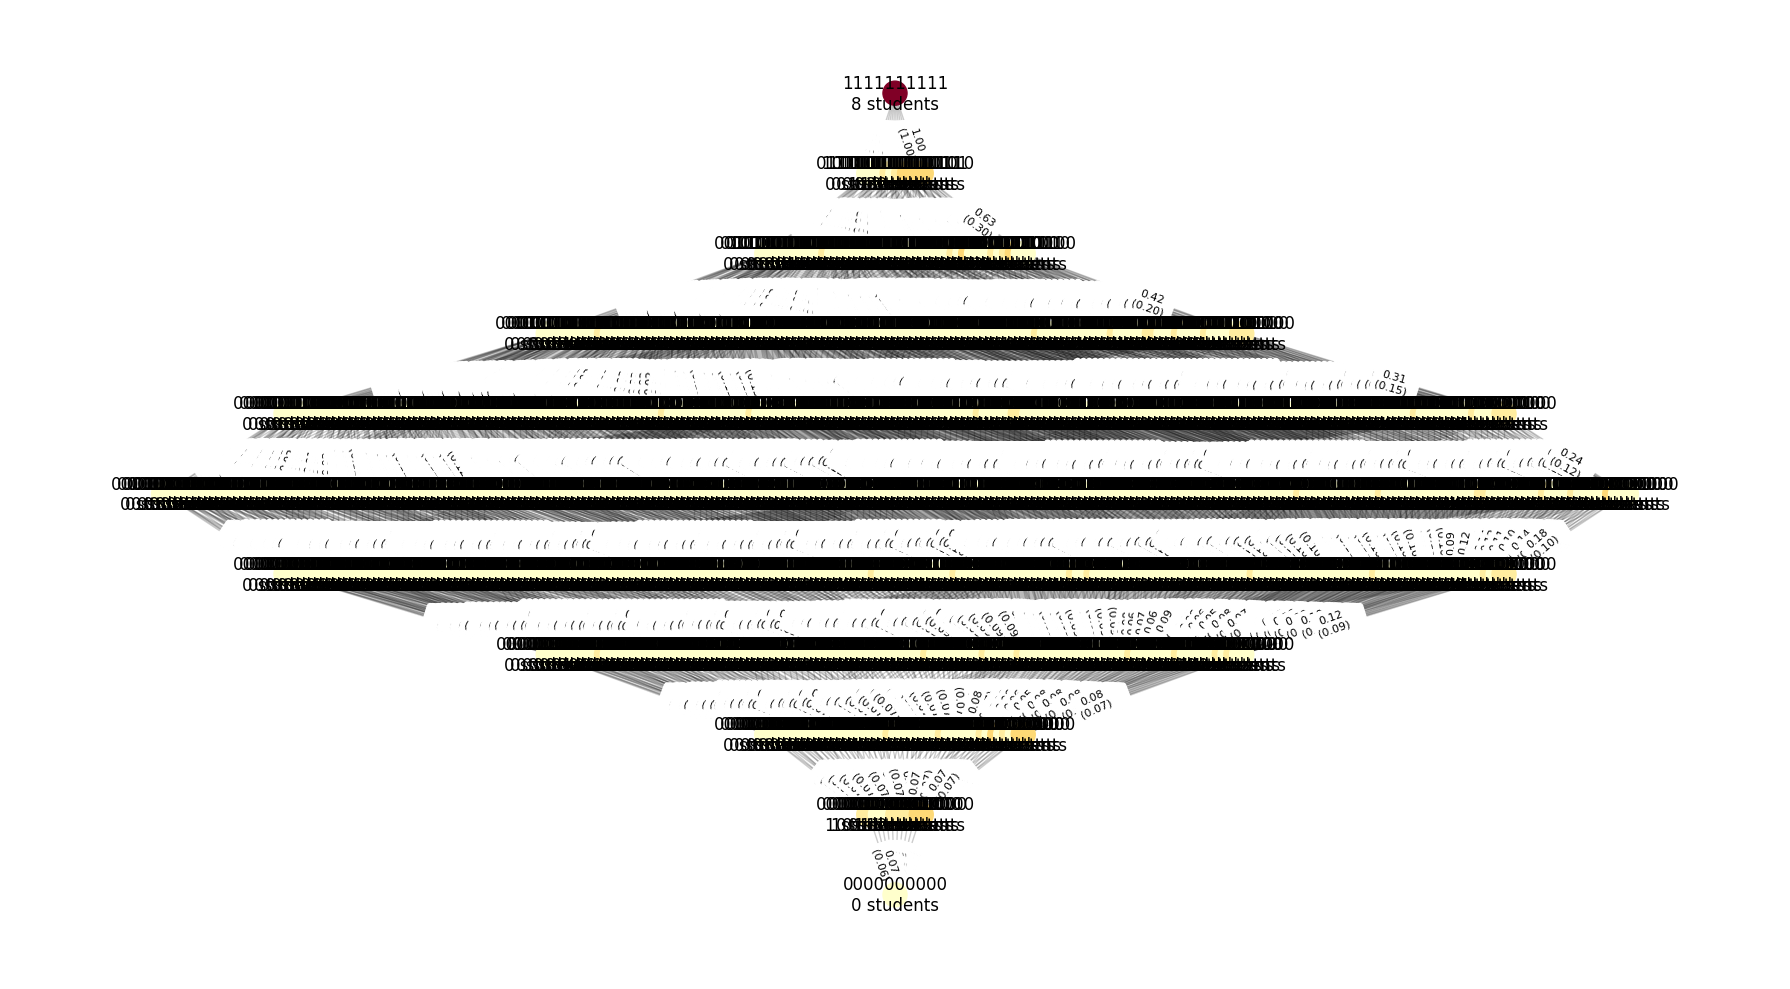

State counts:
State 0000000000: 0 students
State 0010000000: 1 students
State 0000000010: 1 students
State 1000000000: 2 students
State 0000000001: 1 students
State 0100000000: 1 students
State 0001000000: 1 students
State 0000100000: 1 students
State 0000010000: 0 students
State 0000001000: 0 students
State 0000000100: 0 students
State 1100000000: 2 students
State 1000000100: 1 students
State 1000010000: 2 students
State 0010000010: 1 students
State 1001000000: 1 students
State 0100001000: 1 students
State 1000000001: 0 students
State 0100000001: 0 students
State 0010000001: 0 students
State 0001000001: 0 students
State 0000100001: 0 students
State 0000010001: 0 students
State 0000001001: 0 students
State 0000000101: 0 students
State 0000000011: 0 students
State 1000000010: 0 students
State 0100000010: 0 students
State 0001000010: 0 students
State 0000100010: 0 students
State 0000010010: 0 students
State 0000001010: 0 students
State 0000000110: 0 students
State 0100000100: 0 students


In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_components):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_components)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    if state == (1,) * (num_components):  # 最後のノードでは遷移がないのでスキップ
        continue
    
    probabilities = transition_probabilities(A, np.array(state))
    c_g = torch.ones(num_components, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)  # 予算を更新
    print(c_g)
    print(torch.tensor([state], dtype=torch.float32))
    state_tensor = torch.tensor(state, dtype=torch.float32)
    print(state_tensor[1])
    predicted_values = model(state_tensor, c_g)  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"({probabilities[i]:.2f})"
                predicted_value = f"{predicted_values[i]:.2f}"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{predicted_value}\n{transition_probability}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
# plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
# plt.text(
#     0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
#     "edges: predicted probability\n (): true probability",  # 表示したいテキスト
#     horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
#     verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
#     transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
#     fontsize=12,                    # フォントサイズ
#     color="black"                   # テキストの色
# )

# plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")

In [25]:
# 表示オプションを設定（有効数字3桁）
torch.set_printoptions(precision=3, sci_mode=False)
print(A)
for param in model.parameters():
    print(param)

for param in upper_model.parameters():
    print(param)

for param in step_model.parameters():
    print(param)

for param in all_model.parameters():
    print(param)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 0.]]
Parameter containing:
tensor([[ 0.037,  0.028,  0.595,  0.496,  0.058,  0.374,  0.504,  0.571,  0.538,
          0.516],
        [ 0.164,  0.145,  0.499,  0.426,  0.061,  0.491,  0.377,  0.379,  0.052,
          0.313],
        [ 0.019,  0.257,  0.002,  0.070, -0.008,  0.075,  0.004,  0.056, -0.030,
         -0.007],
        [-0.016, -0.118, -0.065,  0.410,  0.320,  0.444,  0.399, -0.096, -0.034,
          0.097],
        [-0.213, -0.014, -0.275, -0.141, -0.182, -0.065,  0.026,  0.022,  0.002,
         -0.012],
        [ 0.035, -0.304, -0.079,  0.035, -0.092,  0.093, -0.050, -0.026, -0.304,
         -0.060],
        [-0.055, -0.179, -0.278, -0.271, -0.303,  0.0